## Replace BG Study

In [1]:
import os, sys
from datetime import datetime, timedelta, timezone
import time
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(),'..','..'))
from src import pandas_helper, cdf, tdd, drawing
import importlib

## Checklist Template

- [ ] Things to check in every dataset
0. [ ] Data
	1. [X] Glossary
		1. [X] List all relevant files and columns
			1. [X] check if exist
			2. [X] Check if there are more column names
			3. [X] Are there other files, not mentioned?
	2. [X] Missing data
		1. [X] Check for null values
	3. [ ] Handle Duplicated Rows (overall)
		1. [ ] Duplicates on special columns (e.g. patient id, datetime)
			1. [ ] How often?
				1. [ ] If often investigate?  Check for correlation (e.g. CGM dups)
				2. [ ] Drop (keep max (`test_get_duplicated_max_indexes`), sum, first?)
	4. [ ] Incomplete Patients
		1. [ ] Keep only patients with data in all datasets (`total_ids = reduce(np.intersect1d, (df_basal.PtID.unique(), df_bolus.PtID.unique(), df_cgm.PtID.unique()))`)
2. [ ] Datetime Strings
	1. [ ] Datetestrings consistent?
		1. [ ] If not, check how to parse it efficiently and correctly. Use `parse_flair_dates` if applicable
	2. [ ] Adjustments made?
		1. [ ] Which one to use?
		2. [ ] Check if adjustments make sense 
			1. [ ] Visually inspect gaps (sample)
			2. [ ] Check summary statistics (do gaps get smaller?)
3. [ ] Timestamps
	1. [ ] All in local time?
		1. [ ] Glossary mentions UTC, timezones?
	2. [ ] Check distributions
		1. [ ] brekfast, lunch dinner peaks? 
		2. [ ] Data consistent with bolus and CGM?
4. [ ] CGMS
	1. [ ] Special Numbers
		1. [ ] Replaced?
5. [ ] Boluses
	1. [ ] Requested vs. Delivered (check what timestamp means)
	2. [ ] Extended bolus part duration
6. [ ] Basals
	1. [ ] Suspends?
	2. [ ] Temporary Basals


## Data

### Files & Relvant Columns

#### Files

The study data folder is named **Loop study public dataset 2023-01-31**

From the ReadMe.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

| File Name| Description| Note|
|------|-----|-----|
| HDeviceCGM,.txt| One record per CGM reading | Similar to what we've seen in Loop (Tidepool structure) |
| HDeviceBasal.txt| | Not included in the JAEB file anymore. Similar to what we've seen in Loop (Tidepool structure)|
| HDeviceBolus.txt| One record per bolus reading from a pump | Similar to what we've seen in Loop (Tidepool structure)|
| HPtRoster.txt|One record per Protocol H PtID obtained |  |

#### Relevant Columns:
The following lists all relevant columns. Other columns were considered irrelevant. Some are still mentioned if they serve the discussion but crossed through.

#### HDeviceCGM.txt
| Field_Name | Description (Glossary) | Notes |
|----|----|-|
| DeviceDtTmDaysFromEnroll | Device date number of days from enrollment| convert to timedelta (unit='days'), add to DeviceTm and arbitrary study start date|
| DeviceTm |Device time | convert to timedelta (H::M:S)|
|DexInternalDtTmDaysFromEnroll|Internal date number of days from enrollment| Seems to be Dexcom time, Not missing as in Loop, let's check if needed.|
|DexInternalTm|Internal time|Seems to be Dexcom time, Not missing as in Loop, let's check if needed.|
| RecordType| Type of data (CGM, Calibration, etc)| Needed to drop calibrations|
| GlucoseValue| Glucose value (units: mg/dL)| |

#### HDeviceBolus.txt
| Field_Name| Description (Glossary) | Notes |
|-|-|-|
| DeviceDtTmDaysFromEnroll | Device date number of days from enrollment| convert to timedelta (unit='days'), add to DeviceTm and arbitrary study start date|
| DeviceTm |Device time | convert to timedelta (H::M:S)|
| BolusType| Subtype of data (ex: "Normal" and "Square" are subtypes of "Bolus" type)||
| Normal | Number of units of normal bolus |Likely the only relevant value.|
| Extended | Number of units for extended delivery | We found that there are 0.4% extended boluses, probably triggered from the pump directly since Loop does not support these.|
| Duration | Time span over which the bolus was delivered (milliseconds for Tidepool data, minutes for Diasend data) | Our analysis shows that Duration refers to the Extended part of a Bolus. However, unclear how to find out wether in ms or minutes. JAEB couldn't answer.|

#### HDeviceBasal.txt
Note: File not included in the JAEB file anymore!

| Field_Name | Description (Glossary) |  Notes|
|--|---|--|
| PtID |  Participant ID | |
| DeviceDtTmDaysFromEnroll | Device date number of days from enrollment| convert to timedelta (unit='days'), add to DeviceTm and arbitrary study start date|
| DeviceTm |Device time | convert to timedelta (H::M:S)|
| BasalType| Basal delivery type|used to find suspends|
| Duration | Actual number of milliseconds basal will be in effect| Used as duration|
| Rate | Number of units per hour |We use this as actual delivery rate|

Note: As in the Loop study dataset, we assume that the Bolus columns: ExpectedNormal, ExpectedDuration, ExpectedExtended (Bolus) and the Basal columns: ExpectedDuration, Percent, SuprBasalType, SuprDuration, SuprRate can be ignored as they don't represent the actual deliveries but amounts that were suppressed. However, we will use them to investigate duplicates.

#### Summary
The tables mostly follow the Tidepool structure 
Differences:
- Timestamps are given relative to enrollment start
- Insulin and InsValue columns exist, however always empty
- CGM values in mgdl not mmol
- Dexcom times seem to be present in all rows
- No timezone offsets are present, probably all in local time

#TODO:
 1. Check if Dexcom times exist and if they are needed
 2. Check if duration is in milliseconds (Bolus)

### Load data

In [2]:
#define path variables
study_name = 'REPLACE-BG Dataset-79f6bdc8-3c51-4736-a39f-c4c0f71d45e5'
raw_path = os.path.join(os.getcwd(), '..', '..', 'data', 'raw')
out_path = os.path.join(os.getcwd(), '..', '..', 'data', 'out')
study_path = os.path.join(raw_path, study_name)
df_basal = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HDeviceBasal.txt'), sep='|')
df_bolus = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HDeviceBolus.txt'), sep='|')
df_patient = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HPtRoster.txt'), sep='|')
df_cgm = pd.read_csv(os.path.join(study_path, 'Data Tables', 'HDeviceCGM.txt'), sep='|')

In [3]:
#convert datetimes and durations
enrollment_start = datetime(2025,1,1)
df_basal['datetime'] = enrollment_start+pd.to_timedelta(df_basal['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_basal['DeviceTm'])
df_bolus['datetime'] = enrollment_start+pd.to_timedelta(df_bolus['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_bolus['DeviceTm'])
df_cgm['datetime'] = enrollment_start+pd.to_timedelta(df_cgm['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_cgm['DeviceTm'])

df_basal['hour_of_day'] = df_basal.datetime.dt.hour
df_bolus['hour_of_day'] = df_bolus.datetime.dt.hour
df_cgm['hour_of_day'] = df_cgm.datetime.dt.hour

df_bolus['day'] = df_bolus.datetime.dt.date
df_basal['day'] = df_basal.datetime.dt.date
df_cgm['day'] = df_cgm.datetime.dt.date


In [4]:
#drop DeviceDtTmDaysFromEnroll and DeviceTm
df_basal.drop(columns=['DeviceDtTmDaysFromEnroll', 'DeviceTm'], inplace=True)
df_bolus.drop(columns=['DeviceDtTmDaysFromEnroll', 'DeviceTm'], inplace=True)
df_cgm.drop(columns=['DeviceDtTmDaysFromEnroll', 'DeviceTm'], inplace=True)

In [5]:
#convert durations
df_basal['Duration'] = pd.to_timedelta(df_basal['Duration'],unit='ms')
df_basal['ExpectedDuration'] = pd.to_timedelta(df_basal['ExpectedDuration'],unit='ms')
df_basal['SuprDuration'] = pd.to_timedelta(df_basal['SuprDuration'],unit='ms')
df_bolus['Duration'] = pd.to_timedelta(df_bolus['Duration'],unit='ms')
df_bolus['ExpectedDuration'] = pd.to_timedelta(df_bolus['ExpectedDuration'],unit='ms')


In [6]:
## drop calibrations
df_cgm = df_cgm.loc[df_cgm.RecordType == 'CGM']

In [7]:
## sort
df_basal.sort_values(by=['PtID','datetime'], inplace=True)
df_bolus.sort_values(by=['PtID','datetime'], inplace=True)
df_cgm.sort_values(by=['PtID','datetime'], inplace=True)

### Missing Data
Check for Null Values

In [8]:
#column counts  (%)
display('Bolus:')
display(100*df_bolus.count()/len(df_bolus))
display('Basal:')
display(100*df_basal.count()/len(df_basal))
display('CGM:')
display(100*df_cgm.count()/len(df_cgm))

'Bolus:'

RecID                     100.000000
ParentHDeviceUploadsID    100.000000
PtID                      100.000000
SiteID                    100.000000
BolusType                 100.000000
InjValue                    0.000000
Insulin                     0.000000
Normal                     98.769320
ExpectedNormal              1.125063
Extended                    5.221328
ExpectedExtended            0.354778
Duration                    5.474809
ExpectedDuration            0.354778
datetime                  100.000000
hour_of_day               100.000000
day                       100.000000
dtype: float64

'Basal:'

RecID                     100.000000
ParentHDeviceUploadsID    100.000000
PtID                      100.000000
SiteID                    100.000000
BasalType                 100.000000
Duration                   99.916074
ExpectedDuration           16.879589
Percnt                      6.147610
Rate                       91.929439
SuprBasalType              12.718023
SuprDuration               11.322436
SuprRate                   12.710484
datetime                  100.000000
hour_of_day               100.000000
day                       100.000000
dtype: float64

'CGM:'

RecID                            100.000000
ParentHDeviceUploadsID           100.000000
PtID                             100.000000
SiteID                           100.000000
DexInternalDtTmDaysFromEnroll     95.996795
DexInternalTm                     95.996795
RecordType                       100.000000
GlucoseValue                     100.000000
datetime                         100.000000
hour_of_day                      100.000000
day                              100.000000
dtype: float64

- Number of Extended and Duration don't match exactly
- Some Dexcom times are missing.

### Duplicates

In [9]:
### duplicates (all rows)
print(f"{df_bolus.duplicated(subset=['PtID', 'datetime','BolusType','Normal','Extended','Duration'],keep=False).sum()} actual duplicates in bolus")
print(f"{df_basal.duplicated(subset=['PtID', 'datetime','Rate','BasalType','Duration'],keep=False).sum()} actual duplicates in basal")
print(f"{df_cgm.duplicated(subset=['PtID', 'datetime','RecordType','GlucoseValue'],keep=False).sum()} actual duplicates in cgm")


8291 actual duplicates in bolus
104091 actual duplicates in basal
1840 actual duplicates in cgm


In [10]:
#drop these duplicates
df_bolus = df_bolus.drop_duplicates(subset=['PtID', 'datetime','BolusType','Normal','Extended','Duration'])
df_basal = df_basal.drop_duplicates(subset=['PtID', 'datetime','Rate','BasalType','Duration'])
df_cgm = df_cgm.drop_duplicates(subset=['PtID', 'datetime','RecordType','GlucoseValue'])

In [11]:
### duplicates (only on datetime)
print(f"{100*df_basal.duplicated(subset=['PtID', 'datetime'],keep=False).sum()/len(df_basal):.2f}% temporal duplicates in basal")
print(f"{100*df_bolus.duplicated(subset=['PtID', 'datetime'],keep=False).sum()/len(df_bolus):.2f}% temporal duplicates in bolus")
print(f"{100*df_cgm.duplicated(subset=['PtID', 'datetime'],keep=False).sum()/len(df_cgm):.2f}% temporal duplicates in cgm")

1.13% temporal duplicates in basal
0.06% temporal duplicates in bolus
0.01% temporal duplicates in cgm


#### Basal Duplicates

In [68]:
#check where temporal duplicates differ
basal_temp_dups = df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime'], keep=False)]

display(f"{len(basal_temp_dups)} basal rows are temporal duplicates")

print('This is where they differ:')
display(pandas_helper.count_differences_in_duplicates(df_basal, subset=['PtID', 'datetime']))

#print some temporal duplicates
display("some examples:")
display(basal_temp_dups.loc[[301126,301125,166899,166901,166903,166927,166928],['PtID', 'datetime', 'Duration','ExpectedDuration', 'Rate','BasalType','Percnt','SuprDuration','SuprRate']])

'5006 basal rows are temporal duplicates'

This is where they differ:


RecID                     2486
ParentHDeviceUploadsID    1872
PtID                         0
SiteID                       0
BasalType                 1183
Duration                  1727
ExpectedDuration          2071
Percnt                     144
Rate                      1256
SuprBasalType             1167
SuprDuration              1119
SuprRate                  1169
datetime                     0
hour_of_day                  0
day                          0
dtype: int64

'some examples:'

,PtID,datetime,Duration,ExpectedDuration,Rate,BasalType,Percnt,SuprDuration,SuprRate
301126,46,2025-04-13 22:36:11,0 days 01:23:49,NaT,NaN,suspend,NaN,0 days 01:23:49,1.00
301125,46,2025-04-13 22:36:11,0 days 00:00:00,0 days 01:23:49,1.00,scheduled,NaN,NaT,NaN
166899,141,2024-11-22 07:00:00,0 days 00:29:58,0 days 14:03:01,0.65,scheduled,NaN,NaT,NaN
166901,141,2024-11-22 07:00:00,0 days 00:49:30,0 days 14:52:38,0.65,scheduled,NaN,NaT,NaN
166903,141,2024-11-22 07:00:00,0 days 02:06:57,0 days 17:00:00,0.65,scheduled,NaN,NaT,NaN
166927,141,2024-11-19 15:24:31,0 days 00:00:00,0 days 08:35:29,0.65,scheduled,NaN,NaT,NaN
166928,141,2024-11-19 15:24:31,0 days 00:00:01,NaT,NaN,suspend,NaN,0 days 08:35:29,0.65


It looks like the suspend event overwrites the scheduled event. But it does not look very consistent. 
 - Sometimes, Durations are empty
 - sometimes the Suppressed duration does not match the scheduled duration. 
Also, the SuprRate does not always match the scheduled rate exactly. In order to better udnerstand what is going on we need to take a look at the data in context.

#### Equal duration & rate
When we have duplicates where datetime, duration and rate are equal, we don't care which one, we just keep one:


In [69]:
#obvious: duplicates: equal duration and rate
temp = df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime','Rate','Duration'],keep=False)]
temp = temp.sort_values(by=['PtID', 'datetime'])
display(temp[['PtID','datetime','Rate','Duration','BasalType','Percnt','SuprDuration','SuprRate']].head(4))

print(f"From all duplicates in basal, {100*len(temp)/len(basal_temp_dups):.2f}% are duplicates in rate and duration")
display(temp.BasalType.value_counts())

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate


From all duplicates in basal, 0.00% are duplicates in rate and duration


Series([], Name: count, dtype: int64)

In [70]:
#drop
df_basal = df_basal.drop_duplicates(subset=['PtID', 'datetime','Rate', 'Duration'],keep='first')
basal_temp_dups = df_basal.loc[df_basal.duplicated(subset=['PtID','datetime'], keep=False)]
print(f"{len(basal_temp_dups)} temporal duplicates are left after removing duplicates in rate and duration")

5006 temporal duplicates are left after removing duplicates in rate and duration


#### Inspecting Duplicates and surrounding Events

In [16]:
import ipywidgets as widgets
from IPython.display import display
import importlib

importlib.reload(pandas_helper)
basal_temp_dups = df_basal.loc[df_basal.duplicated(subset=matching_cols, keep=False)]

# Scroll through the duplicates and get the surrounding rows
def display_surrounding_rows(i):
    index = basal_temp_dups.index[i]
    subframe = pandas_helper.extract_surrounding_rows(df_basal, index, 2, sort_by=['PtID', 'datetime'])
    subframe['end']=subframe['datetime']+subframe['Duration']
    print(subframe.ExpectedDuration.max())
    display(subframe[['PtID','BasalType','datetime', 'Duration', 'end','Rate']])

# Create slider
slider = widgets.IntSlider(min=0, max=len(basal_temp_dups)-1, step=1, description='Index')

# Create buttons
prev_button = widgets.Button(description="Previous")
next_button = widgets.Button(description="Next")
step_buttons = widgets.HBox([prev_button, next_button])  # Put buttons in a row

# Button event handlers
def on_button_clicked(b):
    if b.description == "Previous":
        slider.value = max(slider.value - 1, slider.min)
    elif b.description == "Next":
        slider.value = min(slider.value + 1, slider.max)

# Attach event handlers
prev_button.on_click(on_button_clicked)
next_button.on_click(on_button_clicked)

# Output widget
out = widgets.interactive_output(display_surrounding_rows, {'i': slider})

# Display everything
display(step_buttons, slider, out)

IntSlider(value=0, description='Index', max=5005)

Output()

 For duplicates on suspend/scheduled, it is difficult to say which one to use:
 - Sometimes suspend duration, sometimes scheduled duration match the next row
 - Many durations don't match the next next rows start time 
    - Sometimes (multiple scheduled durations) both match the next datetime

#### Equal duration, different rate
Some duplicates have the same duration. Then the question is which one to pick:

In [73]:
basal_temp_dur_dups = df_basal.loc[df_basal.duplicated(subset=['PtID', 'datetime', 'Duration'],keep=False)]
basal_temp_dur_dups_grped = basal_temp_dur_dups.groupby(['PtID', 'datetime','Duration'],group_keys=False)

print('These are the combinations:')
combinations = basal_temp_dur_dups_grped.apply(lambda x: set(x.BasalType), include_groups=False)
display(combinations.value_counts())

#print examples for each combination
for aset in combinations.value_counts().index:
    display(f'Examples for {aset}:')
    temp = basal_temp_dur_dups_grped.filter(lambda g: set(g['BasalType']) == aset)
    display(temp.head(4)[['PtID','datetime','Rate','Duration','BasalType','Percnt','SuprDuration','SuprRate']])

These are the combinations:


{scheduled, suspend}    689
{scheduled, temp}        50
{scheduled}              17
{temp, suspend}           3
Name: count, dtype: int64

"Examples for {'scheduled', 'suspend'}:"

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
156181,24,2025-02-26 18:00:00,1.2,0 days 06:00:00,scheduled,NaN,NaT,NaN
156300,24,2025-02-26 18:00:00,NaN,0 days 06:00:00,suspend,NaN,0 days 06:00:00,1.1
156134,24,2025-02-27 03:00:00,0.9,0 days 03:00:00,scheduled,NaN,NaT,NaN
157355,24,2025-02-27 03:00:00,NaN,0 days 03:00:00,suspend,NaN,0 days 03:00:00,0.9


"Examples for {'scheduled', 'temp'}:"

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
456962,10,2023-11-06,0.570,0 days 00:03:15,scheduled,NaN,NaT,NaN
456963,10,2023-11-06,0.480,0 days 00:03:15,temp,1.2,NaT,0.4
456948,10,2023-11-07,0.522,0 days 00:01:23,scheduled,NaN,NaT,NaN
456949,10,2023-11-07,0.440,0 days 00:01:23,temp,1.1,NaT,0.4


"Examples for {'scheduled'}:"

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
259969,173,2025-01-30 00:00:00,0.900,0 days 05:00:00,scheduled,NaN,NaT,NaN
259979,173,2025-01-30 00:00:00,0.850,0 days 05:00:00,scheduled,NaN,NaT,NaN
243699,185,2025-07-14 20:30:00,0.025,0 days 03:30:00,scheduled,NaN,NaT,NaN
243700,185,2025-07-14 20:30:00,3.000,0 days 03:30:00,scheduled,NaN,NaT,NaN


"Examples for {'temp', 'suspend'}:"

,PtID,datetime,Rate,Duration,BasalType,Percnt,SuprDuration,SuprRate
157051,24,2025-03-28 03:00:00,0.45,0 days 03:00:00,temp,0.5,0 days 03:00:00,0.9
157156,24,2025-03-28 03:00:00,NaN,0 days 03:00:00,suspend,NaN,0 days 03:00:00,0.9
156026,24,2025-03-29 03:00:00,0.45,0 days 03:00:00,temp,0.5,0 days 03:00:00,0.9
159902,24,2025-03-29 03:00:00,NaN,0 days 03:00:00,suspend,NaN,0 days 03:00:00,0.9


From the exampels we believe the following assumptions should be made: When there are temporal duplicates in time and duration. Then the duplicates should be resolved as follows:
 1. (scheduled or temp) and suspends: keep the suspend, set Rate to 0 (using fillna)
 2. scheduled and temp: use temp over scheduled
 3. Only scheduled: use the maximum value

In [90]:
def filter_duplicates(grp):
    basal_types = set(grp['BasalType'])
    #(scheduled or temp) and suspends: keep the suspend, set Rate to 0 (using fillna)
    if 'suspend' in basal_types:
        return grp.loc[grp.BasalType == 'suspend']
    #scheduled and temp: use temp over scheduled
    elif basal_types == {'scheduled','temp'}:
         return grp.loc[grp.BasalType == 'temp']
    #Only scheduled: use the maximum value
    elif basal_types == {'scheduled'}:
         return grp.loc[[grp.Rate.idxmax()]]

filtered = basal_temp_dur_dups.groupby(['PtID', 'datetime','Duration'], group_keys=False).apply(filter_duplicates)
dups_to_remove = basal_temp_dur_dups.index.difference(filtered.index)

df_basal = df_basal.drop(index=dups_to_remove)

#re-generate temporal duplicates
basal_temp_dups = df_basal.loc[df_basal.duplicated(subset=['PtID','datetime'], keep=False)]

print(f'Dropping {len(dups_to_remove)} indexes, removes {len(basal_temp_dur_dups)} duplicates. {len(basal_temp_dups)} duplicated rows are left')

Dropping 759 indexes, removes 1518 duplicates. 3488 duplicated rows are left


/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_38720/3500514043.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered = basal_temp_dur_dups.groupby(['PtID', 'datetime','Duration'], group_keys=False).apply(filter_duplicates)


Each duplicate were two rowsso we reduce the number by 

In [88]:
print(df_basal.duplicated(subset=['PtID', 'datetime'], keep=False).sum())
print(len(df_basal)-len(df_basal.drop(index=dups_to_remove)))
print(df_basal.drop(index=dups_to_remove).duplicated(subset=['PtID', 'datetime'], keep=False).sum())

5006
759
3488


In [62]:
temp

,RecID,ParentHDeviceUploadsID,PtID,SiteID,BasalType,Duration,ExpectedDuration,Percnt,Rate,SuprBasalType,SuprDuration,SuprRate,datetime,hour_of_day,day
162862,484623,3768,2,14,scheduled,0 days 00:05:01,NaT,NaN,0.900,NaN,NaT,NaN,2024-08-31 21:02:33,21,2024-08-31
162948,484709,3768,2,14,temp,0 days 02:52:26,NaT,NaN,0.108,NaN,NaT,NaN,2024-08-31 21:07:34,21,2024-08-31
162892,484653,3768,2,14,scheduled,1 days 00:00:00,NaT,NaN,0.108,NaN,NaT,NaN,2024-09-01 00:00:00,0,2024-09-01
162911,484672,3768,2,14,scheduled,1 days 00:00:00,NaT,NaN,0.108,NaN,NaT,NaN,2024-09-02 00:00:00,0,2024-09-02
162839,484600,3768,2,14,scheduled,0 days 19:33:48,NaT,NaN,0.108,NaN,NaT,NaN,2024-09-03 00:00:00,0,2024-09-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172399,189990,3272,293,10,scheduled,0 days 02:12:07,NaT,NaN,0.475,NaN,NaT,NaN,2025-07-11 21:47:53,21,2025-07-11
172398,189989,3272,293,10,scheduled,0 days 03:00:00,NaT,NaN,0.400,NaN,NaT,NaN,2025-07-12 00:00:00,0,2025-07-12
172397,189988,3272,293,10,scheduled,0 days 03:00:00,NaT,NaN,0.550,NaN,NaT,NaN,2025-07-12 03:00:00,3,2025-07-12
172396,189987,3272,293,10,scheduled,0 days 03:00:00,NaT,NaN,0.900,NaN,NaT,NaN,2025-07-12 06:00:00,6,2025-07-12


#### Different Durations

We see that within the duplicates, some rows duration don't match the next valid row. These are likely incorrect rows. Therefore, we should drop rows whose datetime+duration does not match the next row's datetime. 

In [18]:
def get_index_next_non_duplicated_row(duplicates, parent_df):
    #keep rows of the same patient
    sub_parent_frame = parent_df.loc[parent_df.PtID==duplicates.PtID.values[0]].sort_values('datetime')
    assert sub_parent_frame.datetime.is_monotonic_increasing
    iloc_max = max([sub_parent_frame.index.get_loc(i) for i in duplicates.index])
    if iloc_max+1 == len(sub_parent_frame):
        return np.nan
    else:
        return sub_parent_frame.iloc[iloc_max+1].datetime
    
grps = basal_temp_dups.groupby(matching_cols)
next_row_datetime = grps.apply(get_index_next_non_duplicated_row, df_basal)
next_row_datetime = next_row_datetime.reset_index().rename(columns={0:'datetime_next'})
#next_row_index['next_datetime']=df_basal.loc[next_row_index.next_index].datetime.values

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_38646/418117528.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  next_row_datetime = grps.apply(get_index_next_non_duplicated_row, df_basal)


In [19]:
test = pd.merge(basal_temp_dups, next_row_datetime, on=['PtID','datetime'], how='inner').sort_values(['PtID','datetime'])
#these are the rows to keep
keep = test.loc[(test.datetime+test.Duration) == test.datetime_next]
display(keep[['PtID','datetime','datetime_next','Rate','BasalType','Duration']].head(10))

,PtID,datetime,datetime_next,Rate,BasalType,Duration
0,3,2025-05-12 14:00:00,2025-05-12 18:00:00,1.400,scheduled,0 days 04:00:00
2,5,2024-10-26 08:00:00,2024-10-26 12:00:00,1.250,scheduled,0 days 04:00:00
4,7,2025-02-11 06:14:50,2025-02-11 06:14:51,NaN,suspend,0 days 00:00:01
6,7,2025-03-09 13:00:00,2025-03-09 18:00:00,0.800,scheduled,0 days 05:00:00
9,8,2025-02-08 00:00:00,2025-02-08 00:04:15,0.700,scheduled,0 days 00:04:15
11,8,2025-02-09 00:00:00,2025-02-09 00:01:35,0.700,scheduled,0 days 00:01:35
13,8,2025-02-10 00:00:00,2025-02-10 00:03:55,0.700,scheduled,0 days 00:03:55
14,10,2023-11-06 00:00:00,2023-11-06 00:03:15,0.570,scheduled,0 days 00:03:15
15,10,2023-11-06 00:00:00,2023-11-06 00:03:15,0.480,temp,0 days 00:03:15
16,10,2023-11-07 00:00:00,2023-11-07 00:01:23,0.522,scheduled,0 days 00:01:23


In [20]:
df_basal.ExpectedDuration.max()

Timedelta('305 days 07:00:40')

## Datetimes

In [21]:
### duplicates (datetime)
print(f"{100*df_basal.duplicated(subset=['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm']).sum()/len(df_basal):.2f}% temporal basal duplicates")
print(f"{100*df_cgm.duplicated(subset=['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm']).sum()/len(df_cgm):.2f}% temporal cgm duplicates")
print(f"{100*df_bolus.duplicated(subset=['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm']).sum()/len(df_bolus):.2f}% temporal bolus duplicates")

KeyError: Index(['DeviceTm', 'DeviceDtTmDaysFromEnroll'], dtype='object')

In [110]:
## look at basal duplicates
temp = df_basal[df_basal.duplicated(subset=['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm'], keep=False)].sort_values(by=['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm'])
#temp = temp[['PtID', 'BasalType','DeviceDtTmDaysFromEnroll', 'DeviceTm', 'Rate', 'Duration','Percnt', 'Rate','SuprRate']]
temp.iloc[1100:1110]

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,BasalType,Duration,ExpectedDuration,Percnt,Rate,SuprBasalType,SuprDuration,SuprRate,datetime,hour_of_day,day
45524,224663,2346,11,15,2,10:00:00,scheduled,19800000.0,NaN,NaN,0.675,NaN,NaN,NaN,2025-01-03 10:00:00,10,2025-01-03
48291,227430,6266,11,15,2,10:00:00,scheduled,19800000.0,NaN,NaN,0.675,NaN,NaN,NaN,2025-01-03 10:00:00,10,2025-01-03
45523,224662,2346,11,15,2,15:30:00,scheduled,9000000.0,NaN,NaN,0.450,NaN,NaN,NaN,2025-01-03 15:30:00,15,2025-01-03
48290,227429,6266,11,15,2,15:30:00,scheduled,9000000.0,NaN,NaN,0.450,NaN,NaN,NaN,2025-01-03 15:30:00,15,2025-01-03
45522,224661,2346,11,15,2,18:00:00,scheduled,12600000.0,NaN,NaN,0.375,NaN,NaN,NaN,2025-01-03 18:00:00,18,2025-01-03
48289,227428,6266,11,15,2,18:00:00,scheduled,12600000.0,NaN,NaN,0.375,NaN,NaN,NaN,2025-01-03 18:00:00,18,2025-01-03
45521,224660,2346,11,15,2,21:30:00,scheduled,9000000.0,NaN,NaN,0.475,NaN,NaN,NaN,2025-01-03 21:30:00,21,2025-01-03
48288,227427,6266,11,15,2,21:30:00,scheduled,9000000.0,NaN,NaN,0.475,NaN,NaN,NaN,2025-01-03 21:30:00,21,2025-01-03
45520,224659,2346,11,15,3,00:00:00,scheduled,10800000.0,NaN,NaN,0.575,NaN,NaN,NaN,2025-01-04 00:00:00,0,2025-01-04
48287,227426,6266,11,15,3,00:00:00,scheduled,10800000.0,NaN,NaN,0.575,NaN,NaN,NaN,2025-01-04 00:00:00,0,2025-01-04


### data hierachy

In [89]:
#unique values (%)
display('Basal Types  (%):')
display(100*df_basal.value_counts(subset=['BasalType'],dropna=False)/df_basal.shape[0])

display('Suspend Rate Values (%):')
display(df_basal.loc[df_basal.BasalType=='suspend'].Rate.value_counts(dropna=False))

display('Bolus Types (%):')
display(100*df_bolus.value_counts(subset=['BolusType'],dropna=False)/df_bolus.shape[0])

display('CGM Types (%):')
display(100*df_cgm.value_counts(subset=['RecordType'],dropna=False)/df_cgm.shape[0])

'Basal Types  (%):'

BasalType
scheduled    84.063831
suspend       8.069371
temp          7.866798
Name: count, dtype: float64

'Suspend Rate Values (%):'

Rate
NaN    40671
Name: count, dtype: int64

'Bolus Types (%):'

BolusType  
normal         91.435169
dual/square     3.989688
Normal          3.090022
square          1.230680
Combination     0.254441
Name: count, dtype: float64

'CGM Types (%):'

RecordType 
CGM            99.042009
Calibration     0.957991
Name: count, dtype: float64

**Summary:**
- Same structure as Loop Dataset
- More suspends (8%) (all NaN), need to be filled with zero and checked if durations match
- Some calibrations, need to be dropped
TODO: 
 1. Check for overlapping durations
 2. Check for Suspend durations match start of next basal

In [93]:
df_basal.Duration

0         19800000.0
1         10800000.0
2          7200000.0
3         10800000.0
4          7200000.0
             ...    
504012     3600000.0
504013     5400000.0
504014     3600000.0
504015     3600000.0
504016    16200000.0
Name: Duration, Length: 504017, dtype: float64

In [90]:
importlib.reload(pandas_helper)
pandas_helper.overlaps(df_basal,'datetime',)

<module 'src.pandas_helper' from '/Users/jan/git/nudgebg/egvinsulin/notebooks/understand-replacebg-dataset/../../src/pandas_helper.py'>

### Datetimes

enrollment_start = datetime(2025,1,1)
df_basal['datetime'] = enrollment_start+pd.to_timedelta(df_basal['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_basal['DeviceTm'])
df_bolus['datetime'] = enrollment_start+pd.to_timedelta(df_bolus['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_bolus['DeviceTm'])
df_cgm['datetime'] = enrollment_start+pd.to_timedelta(df_cgm['DeviceDtTmDaysFromEnroll'],unit='D')+pd.to_timedelta(df_cgm['DeviceTm'])

df_basal['hour_of_day'] = df_basal.datetime.dt.hour
df_bolus['hour_of_day'] = df_bolus.datetime.dt.hour
df_cgm['hour_of_day'] = df_cgm.datetime.dt.hour

df_bolus['day'] = df_bolus.datetime.dt.date
df_basal['day'] = df_basal.datetime.dt.date
df_cgm['day'] = df_cgm.datetime.dt.date

In [ ]:
#drawing.drawMovingAverage(ax, df_basal.dropna(subset='Rate'), 'datetime', 'Rate', 'sum')

In [58]:
#number of unique patients
print(f"There are {df_patient['PtID'].nunique()} unique patients in the patient roster")
print(f"There are {df_bolus['PtID'].nunique()} unique patients in the bolus table")
print(f"There are {df_basal['PtID'].nunique()} unique patients in the basal table")
print(f"There are {df_cgm['PtID'].nunique()} unique patients in the cgm table")

There are 226 unique patients in the patient roster
There are 224 unique patients in the bolus table
There are 208 unique patients in the basal table
There are 226 unique patients in the cgm table


Text(0.5, 1.0, 'CGM Glucose')

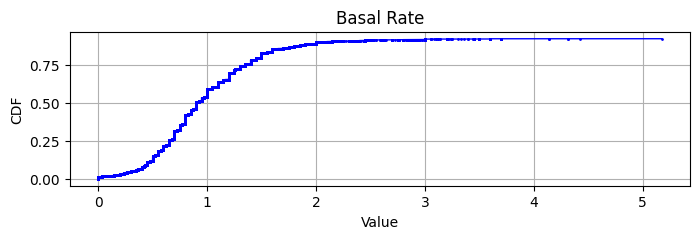

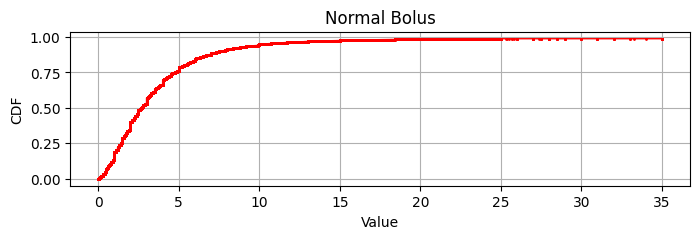

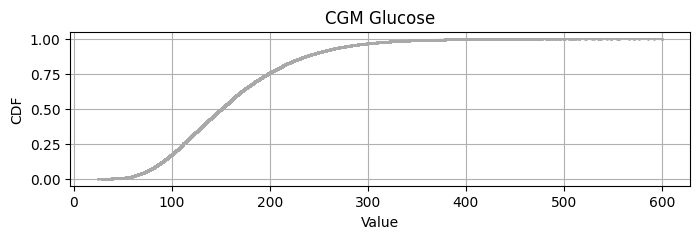

In [ ]:
## distributions 
plt.figure(figsize=(8,2));ax=plt.gca()
cdf.plot_cdf(df_basal['Rate'], ax=ax, label='Basal Rate',color=drawing.colors['Basal']); plt.title('Basal Rate')
plt.figure(figsize=(8,2));ax=plt.gca()
cdf.plot_cdf(df_bolus['Normal'], ax=ax, label='Normal Bolus',color=drawing.colors['Bolus']); plt.title('Normal Bolus')
plt.figure(figsize=(8,2));ax=plt.gca()
cdf.plot_cdf(df_cgm['GlucoseValue'], ax=ax, label='CGM Glucose',color=drawing.colors['CGM']); plt.title('CGM Glucose')

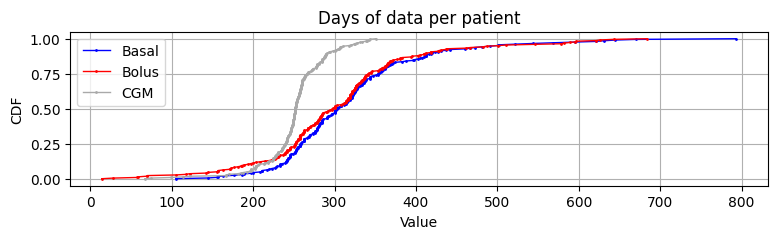

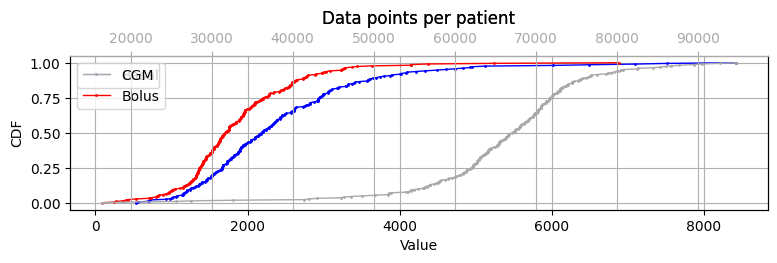

In [ ]:
#number of datapoints per patient
import importlib
importlib.reload(cdf)
#days per patient
plt.figure(figsize=(9,2)); ax=plt.gca()
cdf.plot_cdf(df_basal.groupby('PtID')['day'].nunique(),ax=ax, color=drawing.colors['Basal']); 
cdf.plot_cdf(df_bolus.groupby('PtID')['day'].nunique(),ax=ax, color=drawing.colors['Bolus']); 
cdf.plot_cdf(df_cgm.groupby('PtID')['day'].nunique(),ax=ax, color=drawing.colors['CGM']); 
plt.legend(['Basal','Bolus','CGM']); plt.title('Days of data per patient')

#datapoints
plt.figure(figsize=(9,2)); ax=plt.gca()
cdf.plot_cdf(df_basal.groupby('PtID').size(),ax=ax, color=drawing.colors['Basal']); 
cdf.plot_cdf(df_bolus.groupby('PtID').size(),ax=ax, color=drawing.colors['Bolus']);
plt.legend(['Basal','Bolus']); plt.title('Data points per patient')
twiny = ax.twiny()
cdf.plot_cdf(df_cgm.groupby('PtID').size(),ax=twiny, color=drawing.colors['CGM']);
plt.legend(['CGM']); plt.title('Data points per patient')
twiny.spines['top'].set_color(drawing.colors['CGM'])
twiny.xaxis.label.set_color(drawing.colors['CGM'])
twiny.set_xlabel('')
#twiny.set_xlabel('Data points per patient')
twiny.tick_params(axis='x', colors=drawing.colors['CGM'])

## Collected Todos
- Why do extended and durations not match exactly?
- Do we need Dexcom times? When are these missing
- Are durations in ms or minutes, look at distributions


## Collected Questions
- How should we resolve basal duplicates with equal time and durations but different rates (e.g. scheduled)
- Should we use suspends over other events? And then, is NaN equal to a 0 basal rate? This is how we treated them in T1DExi
- Sometimes their durations don't match.
- Why do durations of basal duplicates sometimes match next 
